## Australian rain dataset

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [60]:
df = pd.read_csv("dataML/weatherAUS.csv")
print(f"Shape: {df.shape}")
print(f"Shape dropping all missing values: {df.dropna().shape}")
print("-------------------------------------------")
print(f"List of columns: {list(df.columns)}")

Shape: (145460, 23)
Shape dropping all missing values: (56420, 23)
-------------------------------------------
List of columns: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


In [4]:
print("Types of variables:")
print(df.dtypes)

Types of variables:
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


In [61]:
# Missing values
print(f"Missing values:")
print(df.isnull().sum())

Missing values:
Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


### Handle missing values:
**Cloud9am, Cloud3pm** --> DROP COLUMNS (too many datapoints lost if missing values are dropped (~50%), but probably bad info if nan replaced with average over given period or other methods).

**Evaporation, Sunshine** --> DROP COLUMNS (too many datapoints lost if missing values are dropped (~50%), prefer to drop to avoid having too many datapoints created instead of collected).


**Rainfall, MinTemp, Maxtemp, Temp9am, Humidity9am, Temp3pm, Humidity3pm, Pressure9am, Pressure3pm** --> forward fill  (all these features depend on the period of the year, hence better to use the closets datapoint in time, not average for the entire sample). ***!! this is ok only if we consider the same location, because otherwise we might replace with a value from a different location with very different weather conditions)***


**WindGustSpeed, WindSpeed9am, WindSpeed3pm** --> DROP MISSING VALUES (does average make sense? probably not).

**WindGustDir, WindDir9am, WindDir3pm** --> DROP MISSING VALUES (not numbers, no good way to substitue, we can't know the value, we don't know if nan means no wind or just not recorded data).

**RainToday, RainTomorrow** --> DROP MISSING VALUES (we don't know the value, we can't substitute),

In [62]:
print(df["Location"].unique())
print(f"Number of different locations: {len(df['Location'].unique())}")
print("--------------------------------------------------")
print("Unique values for wind variables:")
print(df["WindGustDir"].unique())
print(df["WindDir9am"].unique())
print(df["WindDir3pm"].unique())
# Location could be transformed into bigger groups, like north, south, east and west region and use as dummy --> not implemented here
# We could focus on specific Locations/Areas --> see below

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
Number of different locations: 49
--------------------------------------------------
Unique values for wind variables:
['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' nan 'ENE' 'SSE' 'S' 'NW' 'SE'
 'ESE' 'E' 'SSW']
['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' nan 'SSW' 'N' 'WSW' 'ESE' 'E'
 'NW' 'WNW' 'NNE']
['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' nan 'NE']


# Create new dataframe with only data for Sydney
Use only few locations to have less datapoints and hence faster nested CV example

In [63]:
####### Create dataframe and handle missing values
starting_df = pd.read_csv("dataML/weatherAUS.csv")

target_locs = ["Sydney", "SydneyAirport"]
dataframes_locs = []
seasons_map = {int(1): 0, int(2): 0, int(3): 0, int(4): 0, int(5): 0, int(6): 1, int(7): 1, int(8): 1, int(9): 0, int(10): 0, int(11): 0, int(12):0}

# loop over all the locations and create a dataframe for each one (required for correct forward fill)
# then concatenate all and shuffle 
for location in target_locs:
    df = starting_df[starting_df["Location"].isin([location])]
    df = df.sort_values("Date")  
    df["Season"] = (pd.to_datetime(df['Date']).dt.month)
    # Map categorical (0 for no winter, 1 for winter months)
    df = df.replace({'Season': seasons_map,'RainToday': {'Yes': 1, 'No': 0}, 'RainTomorrow': {'Yes': 1, 'No': 0}})
    # Drop NaN (for columns identified above)
    df = df.dropna(subset=["WindGustSpeed", "RainToday", "RainTomorrow"])
    # Drop columns (for columns identified above, also drop all wind variables except WindGustSpeed (distribution ok) in this case)
    df = df.drop(["Date", "Location", "Cloud9am", "Cloud3pm", "Evaporation", "Sunshine", "WindSpeed9am", "WindSpeed3pm", "WindGustDir", "WindDir9am", "WindDir3pm"], axis=1)
    df = df.fillna(method="ffill", axis=0)
    df = df.fillna(method="bfill", axis=0)
    dataframes_locs.append(df)

ausSyddf = pd.concat(dataframes_locs).sample(frac=1)
ausSyddf.shape

(5247, 13)

In [64]:
# Correlation between features
correl_mat = ausSyddf[['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed','Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']].corr()
correl_mat.style.background_gradient(cmap="coolwarm")

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
MinTemp,1.000000,0.756899,0.007944,0.186880,0.153494,0.234012,-0.390848,-0.354732,0.923138,0.732319
MaxTemp,0.756899,1.000000,-0.147333,0.127479,-0.153037,-0.228062,-0.386231,-0.442709,0.867727,0.961521
Rainfall,0.007944,-0.147333,1.000000,0.151370,0.336129,0.297359,-0.053620,-0.010352,-0.071943,-0.154576
WindGustSpeed,0.186880,0.127479,0.151370,1.000000,-0.217601,-0.077947,-0.473116,-0.406682,0.216820,0.080042
Humidity9am,0.153494,-0.153037,0.336129,-0.217601,1.000000,0.671083,0.189953,0.199737,-0.090475,-0.131591
Humidity3pm,0.234012,-0.228062,0.297359,-0.077947,0.671083,1.000000,0.149358,0.209584,0.056799,-0.298546
Pressure9am,-0.390848,-0.386231,-0.053620,-0.473116,0.189953,0.149358,1.000000,0.960222,-0.405933,-0.339601
Pressure3pm,-0.354732,-0.442709,-0.010352,-0.406682,0.199737,0.209584,0.960222,1.000000,-0.401000,-0.408565
Temp9am,0.923138,0.867727,-0.071943,0.216820,-0.090475,0.056799,-0.405933,-0.401000,1.000000,0.831958
Temp3pm,0.732319,0.961521,-0.154576,0.080042,-0.131591,-0.298546,-0.339601,-0.408565,0.831958,1.000000


In [65]:
####### Basic Features selection
# drop MinTemp and MaxTemp --> very high correlation with 9am and 3pm temperature
# drop temp9am --> very high correlation with temp3pm
# drop Pressure9am --> very high correlation with pressure3am

ausSyddf = ausSyddf.drop(["MinTemp", "MaxTemp", "Temp9am", "Pressure9am"], axis=1)

## 2) Hyperparameters tuning and Model Selection

We will be using the SW area dataset (ausSyddf), to show the functioning of some of functions for nested cross validation.

In [72]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_roc_curve, classification_report, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
# nested_CV functions in my file
from AG_nested_CrossVal import inner_CV_setup, nestedCV_model_selection, final_tuning

In [73]:
# Showing how SMOTE + RandomUnderSampler works (suggested to use them combined)
# show initial imbalanced
x = ausSyddf.drop("RainTomorrow", axis=1)
y = ausSyddf["RainTomorrow"]
counter1 = Counter(y)
print(f"Initial imbalance: {counter1}")

over = SMOTE(sampling_strategy=0.75)
under = RandomUnderSampler(sampling_strategy=0.8)
pipeline_balance = Pipeline([("O", over),("U", under)])
# transform the dataset
balancedX, balancedy = pipeline_balance.fit_resample(x, y)

counter2 = Counter(balancedy)
print(f"Balanced class: {counter2}, percentage of class 1 on total: {round(counter2[1.0]/(counter2[0.0]+counter2[1.0])*100, 2)}%")

Initial imbalance: Counter({0.0: 3895, 1.0: 1352})
Balanced class: Counter({0.0: 3651, 1.0: 2921}), percentage of class 1 on total: 44.45%


In [74]:
# 1)  Define the final evaluation set
X_train, X_final_eval, y_train, y_final_eval = train_test_split(ausSyddf.drop("RainTomorrow", axis=1), ausSyddf["RainTomorrow"], test_size=0.15, random_state=111)

In [77]:
# 2) Example of Model selection with nested CV + pipelines
# a.1) prepare pipelines
pipe_knn = Pipeline([("bal1", SMOTE(sampling_strategy=0.75)), ("bal2", RandomUnderSampler(sampling_strategy=0.8)), ("scale", MinMaxScaler()), ("est1", KNeighborsClassifier())])
pipe_boost = Pipeline([("est2", RandomForestClassifier(class_weight="balanced_subsample"))])    # handle imbalance in the model
pipe_lda = Pipeline([("bal1", SMOTE(sampling_strategy=0.75)), ("bal2", RandomUnderSampler(sampling_strategy=0.8)), ("scale", MinMaxScaler()), ("est3", LinearDiscriminantAnalysis())])
pipe_svc = Pipeline([("scale", MinMaxScaler()), ("est4", SVC(class_weight = "balanced"))])   # handle imbalance in the model

# a.2) prepare the inner cv
models = (pipe_knn, pipe_boost, pipe_lda, pipe_svc)  # could be pipelines or simple models
param_grids = ([{"est1__n_neighbors": [5, 10, 25, 50], "est1__weights": ['uniform', 'distance']}],
                [{"est2__n_estimators": [50, 100, 150], "est2__criterion": ["gini", "entropy"]}],
                [{"est3__shrinkage": [None]}],
                [{"est4__C": [0.5, 1, 5], "est4__gamma": ["auto", "scale"]}])

mod_names = ("kNN", "RandomForest", "LDA", "SVC")

dict_CVgrids = inner_CV_setup(models, param_grids, mod_names, 3, scoring_metric="f1", seed=33)  # stratifiedKfold and GridSearchCV for inner CV (seed used to set random_seed)

# b) perform nested CV
nestedCV_results = nestedCV_model_selection(dict_CVgrids, 3, X_train, y_train, scoring_metric="f1", seed=22)  # stratifiedKfold for outer CV
nestedCV_results

,LDA,RandomForest,SVC,kNN
OuterCV_average_Score%,63.260203,59.731364,63.944083,61.930496
OuterCV_std%,0.878526,1.705737,0.148087,0.772589


## 3) Final Hyperparameters tuning and Evaluation for the best model

In [84]:
# Identify best model --> SVC
best_pipe = Pipeline([("scale", MinMaxScaler()), ("best_est", SVC(class_weight = "balanced"))])
# Define parameters grid used for the final hyperparams tuning (could be different or same as before)
best_grid = [{"best_est__C": [0.1, 0.5, 1, 3, 5], "best_est__gamma": ["auto", "scale"]}]

# Final hyperparams tuning (in this case best_mod_tuned is a Pipeline object)
best_mod_tuned = final_tuning(best_pipe, best_grid, 4, X_train, y_train, scoring_metric="f1", seed=11)  # stratifiedKfold and GridSearchCV
print("Best model with tuned hyperparameters:")
print(best_mod_tuned)

Best model with tuned hyperparameters:
Pipeline(steps=[('scale', MinMaxScaler()),
                ('best_est', SVC(C=3, class_weight='balanced'))])


In [80]:
# Final evaluation to the best tuned models
best_mod_tuned.fit(X_train, y_train)
predictions = best_mod_tuned.predict(X_final_eval)
print(classification_report(y_final_eval, predictions))

              precision    recall  f1-score   support

         0.0       0.87      0.79      0.83       591
         1.0       0.51      0.65      0.57       197

    accuracy                           0.76       788
   macro avg       0.69      0.72      0.70       788
weighted avg       0.78      0.76      0.77       788



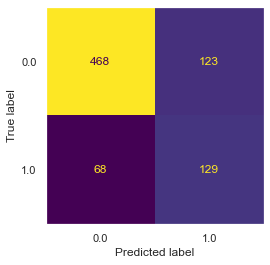

In [81]:
plot_confusion_matrix(best_mod_tuned, X_final_eval, y_final_eval, colorbar=False)
plt.grid();  # remove sns grid

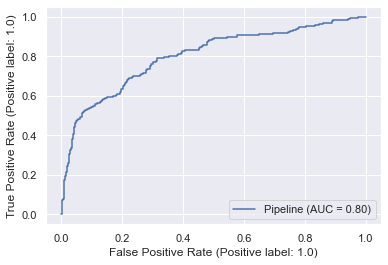

In [82]:
plot_roc_curve(best_mod_tuned, X_final_eval, y_final_eval);

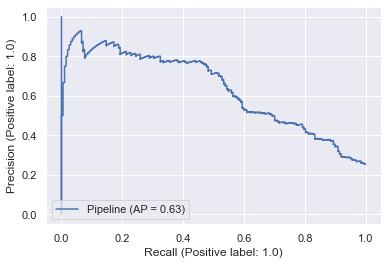

In [83]:
plot_precision_recall_curve(best_mod_tuned, X_final_eval, y_final_eval);